In [1]:
# Install dan import
!pip install -q tensorflow matplotlib scikit-learn

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Path ke dataset Anda
data_dir = '/content/drive/MyDrive/klasifikasi/dataset'

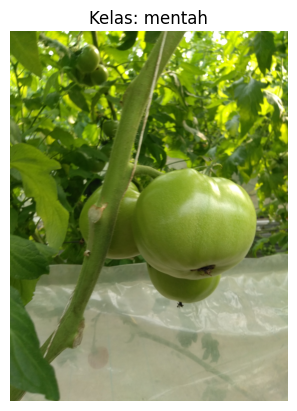

In [4]:
# Visualisasi satu gambar secara acak
import matplotlib.image as mpimg
import random

class_folders = os.listdir(data_dir)
selected_class = random.choice(class_folders)
image_path = os.path.join(data_dir, selected_class, random.choice(os.listdir(os.path.join(data_dir, selected_class))))
img = mpimg.imread(image_path)

plt.imshow(img)
plt.title(f"Kelas: {selected_class}")
plt.axis('off')
plt.show()


In [5]:
#Split Data Menjadi Train, Validation, Test
batch_size = 32
img_size = (128, 128)

train_datagen = ImageDataGenerator(
    validation_split=0.4,
    rescale=1./255,
    rotation_range=40,
    zoom_range=0.4,
    width_shift_range=0.4,
    height_shift_range=0.4,
    horizontal_flip=True,
    shear_range=0.4,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    subset='training',
    class_mode='categorical',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)


Found 900 images belonging to 3 classes.
Found 599 images belonging to 3 classes.
Found 1499 images belonging to 3 classes.


In [6]:
#Tampilkan informasi persentase split data
total_train = train_generator.samples
total_val = val_generator.samples
total_all = total_train + total_val

train_percent = (total_train / total_all) * 100
val_percent = (total_val / total_all) * 100

print(f"\nTotal Data: {total_all}")
print(f"Train: {total_train} gambar ({train_percent:.2f}%)")
print(f"Validation: {total_val} gambar ({val_percent:.2f}%)")


Total Data: 1499
Train: 900 gambar (60.04%)
Validation: 599 gambar (39.96%)


In [7]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False
base_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_1.00_128"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.6),
    layers.Dense(3, activation='softmax')
])

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(2e-4),  # Learning rate lebih kecil
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
start_time = time.time()

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)
end_time = time.time()

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
13/29 ━━━━━━━━━━━━━━━━━━━━ 2:27 9s/step - accuracy: 0.4223 - loss: 1.4957

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


29/29 ━━━━━━━━━━━━━━━━━━━━ 487s 17s/step - accuracy: 0.4926 - loss: 1.2805 - val_accuracy: 0.6845 - val_loss: 0.7158
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.8254 - loss: 0.4881 - val_accuracy: 0.7129 - val_loss: 0.6199
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.9047 - loss: 0.3039 - val_accuracy: 0.7212 - val_loss: 0.6448
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.9165 - loss: 0.2440 - val_accuracy: 0.7245 - val_loss: 0.6228
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step - accuracy: 0.9099 - loss: 0.2227 - val_accuracy: 0.7579 - val_loss: 0.5640
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 113s 4s/step - accuracy: 0.9376 - loss: 0.2136 - val_accuracy: 0.7329 - val_loss: 0.5867
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step - accuracy: 0.9268 - loss: 0.1969 - val_accuracy: 0.7579 - val_loss: 0.6179
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.9491 - loss: 0.1748 - val_accuracy: 0.7796 - val_loss: 0.5008

In [11]:

duration = end_time - start_time
minutes = int(duration // 60)
seconds = int(duration % 60)
print(f"\nDurasi training: {minutes} menit {seconds} detik")


Durasi training: 35 menit 13 detik


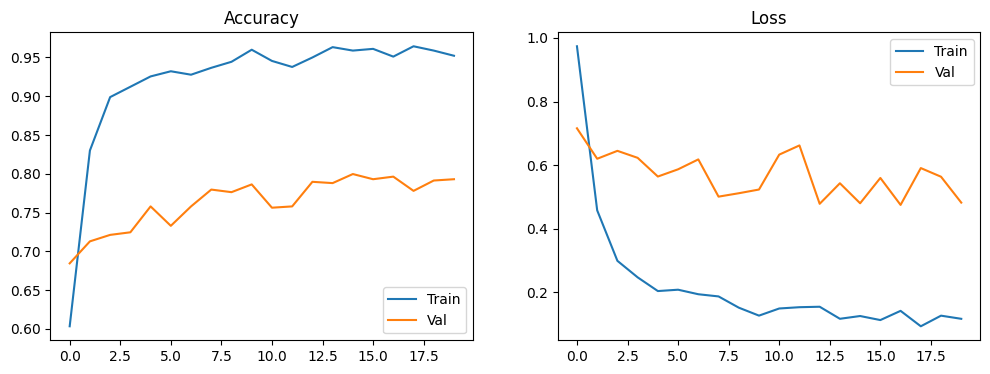

In [12]:
# Plotting history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()

plt.show()

In [13]:
# Evaluasi model pada data test
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

1499/1499 ━━━━━━━━━━━━━━━━━━━━ 79s 52ms/step - accuracy: 0.7868 - loss: 0.4588
Test Loss: 0.15106861293315887
Test Accuracy: 0.9326217770576477


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


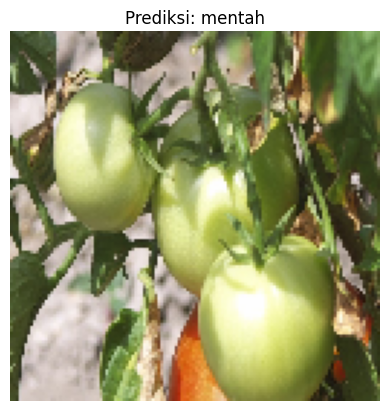

In [14]:
#Prediksi Gambar Secara Acak
class_labels = list(train_generator.class_indices.keys())

# Ambil gambar acak dari test set
rand_index = random.randint(0, len(test_generator.filenames) - 1)
img_path = os.path.join(data_dir, test_generator.filenames[rand_index])
img = tf.keras.utils.load_img(img_path, target_size=img_size)
img_array = tf.keras.utils.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
predicted_class = class_labels[np.argmax(prediction)]

plt.imshow(img)
plt.title(f"Prediksi: {predicted_class}")
plt.axis('off')
plt.show()

 742/1499 ━━━━━━━━━━━━━━━━━━━━ 35s 47ms/step

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1499/1499 ━━━━━━━━━━━━━━━━━━━━ 78s 51ms/step


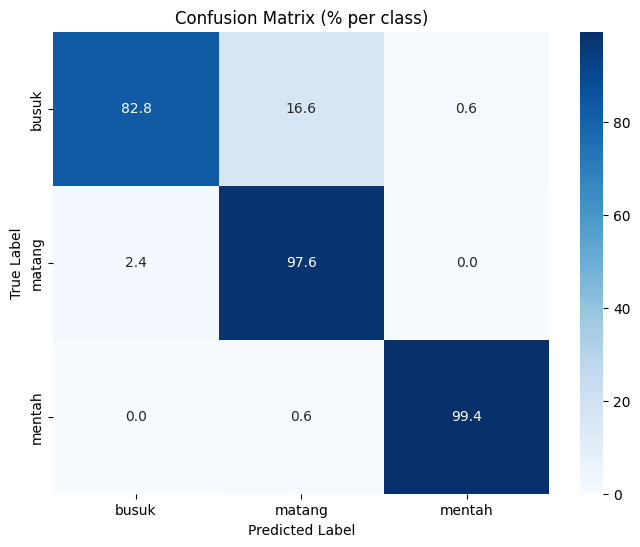

In [15]:
#Confusion Matrix
import seaborn as sns

# Hitung prediksi dan ground truth dari test set
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes  # Label asli
# Hitung confusion matrix dan normalisasi per baris (opsional)
cm = confusion_matrix(y_true, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix (% per class)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [16]:
#Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

Classification Report:
              precision    recall  f1-score   support

       busuk       0.97      0.83      0.89       499
      matang       0.85      0.98      0.91       500
      mentah       0.99      0.99      0.99       500

    accuracy                           0.93      1499
   macro avg       0.94      0.93      0.93      1499
weighted avg       0.94      0.93      0.93      1499



In [17]:
#Konversi ke TFLite
# Simpan model
model.save('mobilenet.h5')

# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan ke file .tflite
with open('mobilenet.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model telah dikonversi dan disimpan sebagai mobilenet.tflite")


Saved artifact at '/tmp/tmpyipsgyce'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  132989730045200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132989730750096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132989730748368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132989730045392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132989730045776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132989730045584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132989730748176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132989730738576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132989730748560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132989730749328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1329897307